In [1]:
import sys
sys.path.append('../..')
from src.pomdp import *

import pandas as pd
import numpy as np

## Model definition

In [2]:
# olfactory_data = pd.read_csv('./Data/statistics_nose_3e6_35_153.dat', sep=',', header=None).values

In [3]:
olfactory_data = pd.read_csv('./Data/statistics_nose_5e6.dat', sep=' ', skiprows=[0], header=None).values.T

In [4]:
# Model size
# env_shape = (280, 1225)
# env_shape = (70,153)
env_shape = olfactory_data.shape
state_count = env_shape[0] * env_shape[1]

print(f'Environment shape: {env_shape}')
print(f'State count: {state_count}')

Environment shape: (321, 1300)
State count: 417300


In [5]:
# goal state
olfactory_data[17,0]

0.0

In [6]:
def id_from_pos(x,y):
    return (x * env_shape[1]) + y

In [7]:
# states
state_grid = []

# Rewards
# rewards = np.zeros((state_count, 4, state_count,2))
# rewards[:,:,id_from_pos(17,0),:] = 1

# observation matrix
flattened_olfactory_data = olfactory_data.flatten()

# observations = np.zeros((state_count, 4, 2))
# observations[:,:,0] = flattened_olfactory_data.reshape((flattened_olfactory_data.shape[0],1)).repeat(4, axis=1)
# observations[:,:,1] = (1 - observations[:,:,0])

# Transitions and state labels
for i in range(env_shape[0]):
    i_states = []
    for j in range(env_shape[1]):
        i_states.append(f's_{i}_{j}')

    state_grid.append(i_states)

In [8]:
row_w = env_shape[1]

reachable_states = np.zeros((state_count, 4, 1), dtype=int)
for s in range(state_count):
    reachable_states[s,0,0] = s - row_w if s - row_w >= 0 else s # North
    reachable_states[s,1,0] = s + 1 if (s + 1) % row_w > 0 else s # East
    reachable_states[s,2,0] = s + row_w if s + row_w < state_count else s # South
    reachable_states[s,3,0] = s - 1 if (s - 1) % row_w < (row_w - 1) else s # West

In [9]:
model = Model(
    states=state_grid,
    actions=['N','E','S','W'],
    observations=['something', 'nothing'],
    reachable_states=reachable_states,
    rewards=(lambda s,a,sn,o: 1.0 if sn==(env_shape[1] * 17) else 0.0),
    # observation_table=observations,
    end_states=[id_from_pos(17,0)]
)

[09/22/2023, 19:30:52] Instantiation of MDP Model:
[09/22/2023, 19:30:52] - 417300 states
[09/22/2023, 19:30:52] - 4 actions
[09/22/2023, 19:30:52] - At most 1 reachable states per state-action pair
[09/22/2023, 19:30:52] - Starting generation of transitions table
[Warning] No transition matrix or function provided but reachable states are, so probability to reach any reachable states will "1 / reachable state count" so here: 1.000.
[09/22/2023, 19:30:52]     > Done in 0.000s
[09/22/2023, 19:30:52] - Generating start probabilities table
[09/22/2023, 19:30:52] - Starting computation of reachable state probabilities from transition data
[09/22/2023, 19:30:52]     > Done in 0.011s
[09/22/2023, 19:30:52] - POMDP particular parameters:
[09/22/2023, 19:30:52] - 2 observations
[09/22/2023, 19:30:52] - Starting of transitional observations for reachable states table
[09/22/2023, 19:30:55]     > Done in 2.484s
[09/22/2023, 19:30:55] - Starting generation of expected rewards table
[09/22/2023, 1

## Experiments

In [9]:
b = Belief(model)
beliefs = np.array([b])
beliefs = beliefs.repeat(1000,axis=0)

In [10]:
value_function = np.array(ValueFunction(model, [AlphaVector(model.expected_rewards_table[:,a], a) for a in model.actions]))
value_function = np.tile(value_function, (250,1))

In [11]:
gamma = 0.99
gamma_a_o_t = gamma * np.einsum('saor,vsar->aovs', model.reachable_transitional_observation_table, value_function.take(model.reachable_states, axis=1))

In [59]:
# Reworked 2
def t3():
    best_alpha_ind = np.argmax(np.tensordot(beliefs, gamma_a_o_t, (1,3)), axis=3)

    best_alphas_per_o = np.zeros((*best_alpha_ind.shape, model.state_count))
    it = np.nditer(best_alpha_ind, flags=['multi_index'], op_flags=['readonly'])
    for x in it:
        (b,a,o) = it.multi_index
        best_alphas_per_o[b,a,o,:] = gamma_a_o_t[a,o,x,:]

    alpha_a = np.sum(best_alphas_per_o, axis=2)
    alpha_a += model.expected_rewards_table.T

    new_value_function = np.zeros(beliefs.shape)
    for i, b in enumerate(beliefs):
        best_ind = np.argmax(np.dot(alpha_a[i,:,:], b))
        new_value_function[i,:] = alpha_a[i, best_ind,:]

In [60]:
%timeit t3()

950 ms ± 69.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [31]:
# Reworked
def t2():
    best_alpha_ind = np.argmax(np.dot(beliefs, gamma_a_o_t.swapaxes(3,2)), axis=3)

    best_alphas_per_o = np.zeros((*best_alpha_ind.shape, model.state_count))
    it = np.nditer(best_alpha_ind, flags=['multi_index'], op_flags=['readonly'])
    for x in it:
        (b,a,o) = it.multi_index
        best_alphas_per_o[b,a,o,:] = gamma_a_o_t[a,o,x,:]

    alpha_a = np.sum(best_alphas_per_o, axis=2)
    alpha_a += model.expected_rewards_table.T

    new_value_function = np.zeros(beliefs.shape)
    for i, b in enumerate(beliefs):
        best_ind = np.argmax(np.dot(alpha_a[i,:,:], b))
        new_value_function[i,:] = alpha_a[i, best_ind,:]

In [32]:
%timeit t2()

34.8 s ± 1.48 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [23]:
def t1():
    for b in beliefs:
        best_alpha = None
        best_alpha_val = -np.inf

        for a in model.actions:
            
            obs_alpha_sum = np.zeros(model.state_count)
            
            for o in model.observations:
                
                # Argmax of alphas
                best_alpha_o = np.zeros(model.state_count)
                best_alpha_o_val = -np.inf
                
                for alpha_o in gamma_a_o_t[a][o]:
                    val = np.dot(alpha_o, b)
                    if val > best_alpha_o_val:
                        best_alpha_o_val = val
                        best_alpha_o = alpha_o
                        
                # Sum of the alpha_obs vectors
                obs_alpha_sum += best_alpha_o

            alpha_a_vect = model.expected_rewards_table[:,a] + obs_alpha_sum

            # Step 3
            val = np.dot(alpha_a_vect, b)
            if val > best_alpha_val:
                best_alpha_val = val
                best_alpha = AlphaVector(alpha_a_vect, a)

In [24]:
%timeit t1()

3min 37s ± 3.97 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


## VI Solve

In [8]:
from src.mdp import VI_Solver

In [9]:
solver = VI_Solver()

In [10]:
solution, history = solver.solve(model)

  0%|          | 0/10000 [00:00<?, ?it/s]

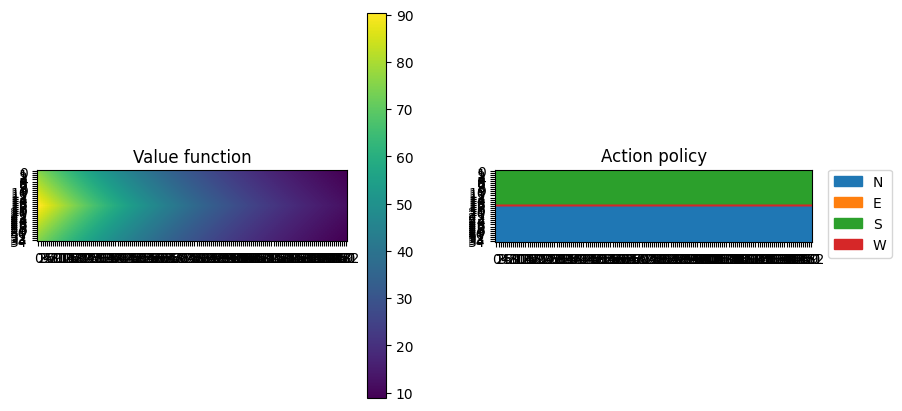

In [11]:
solution.plot()

In [13]:
np.array(solution).shape

(4, 5355)

## Solving timing

regular size

In [8]:
solver = PBVI_Solver(eps=10e-5)
value_function = ValueFunction(model, [AlphaVector(model.expected_rewards_table[:,a], a) for a in model.actions])
belief_set = [Belief(model)]

In [10]:
%timeit solver.backup(model, belief_set, value_function)

670 ms ± 19 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


double size

In [8]:
solver = PBVI_Solver(eps=10e-5)
value_function = ValueFunction(model, [AlphaVector(model.expected_rewards_table[:,a], a) for a in model.actions])
belief_set = [Belief(model)]

In [9]:
%timeit solver.backup(model, belief_set, value_function)

45.9 s ± 618 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


regular size (reachable)

In [8]:
solver = PBVI_Solver(eps=10e-5)
value_function = ValueFunction(model, [AlphaVector(model.expected_rewards_table[:,a], a) for a in model.actions])
belief_set = [Belief(model)]

In [9]:
%timeit solver.backup(model, belief_set, value_function)

2.57 ms ± 80.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Double size (reachable)

In [8]:
solver = PBVI_Solver(eps=10e-5)

In [10]:
value_function = ValueFunction(model, [AlphaVector(model.expected_rewards_table[:,a], a) for a in model.actions])
belief_set = [Belief(model)]

In [11]:
%timeit solver.backup(model, belief_set, value_function)

10.9 ms ± 418 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## Solving profiling

In [13]:
solver = PBVI_Solver(eps=10e-8)

In [14]:
# solution, history = solver.solve(model, 8, 8)

In [15]:
from cProfile import Profile
from pstats import SortKey, Stats


with Profile() as profile:
    solver.solve(model, 4, 8)
    print(f"")
    (
        Stats(profile)
        .strip_dirs()
        .sort_stats(SortKey.CALLS)
        .print_stats()
    )

Expansions:   0%|          | 0/4 [00:00<?, ?it/s]

Backups 0:   0%|          | 0/8 [00:00<?, ?it/s]

Backups 1:   0%|          | 0/8 [00:00<?, ?it/s]

Backups 2:   0%|          | 0/8 [00:00<?, ?it/s]

Backups 3:   0%|          | 0/8 [00:00<?, ?it/s]


         100762 function calls (92817 primitive calls) in 22.482 seconds

   Ordered by: call count

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
10169/7074    0.004    0.000    0.032    0.000 traitlets.py:692(__get__)
     8724    0.002    0.000    0.002    0.000 {built-in method builtins.isinstance}
8503/6483    0.004    0.000    0.029    0.000 traitlets.py:654(get)
6672/4417    0.003    0.000    0.027    0.000 {built-in method builtins.getattr}
     4030    0.001    0.000    0.001    0.000 {method 'get' of 'dict' objects}
     3208    0.001    0.000    0.002    0.000 {built-in method builtins.hasattr}
     2551    0.001    0.000    0.001    0.000 {built-in method builtins.len}
     2130    0.000    0.000    0.000    0.000 {method 'items' of 'dict' objects}
     1780    0.000    0.000    0.000    0.000 {built-in method builtins.callable}
     1725    0.000    0.000    0.000    0.000 traitlets.py:263(__init__)
     1725    0.000    0.000    0.000    0.000 t